In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score

# Student grade prediction dataset

#### dataset - https://www.kaggle.com/datasets/dipam7/student-grade-prediction

In [2]:
df = pd.read_csv('./student grade dataset/student-mat.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Check for null values

In [3]:
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

### Convert columns with nominal values to ordinal values using OneHotEncoding

In [4]:
cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

enc = preprocessing.OneHotEncoder(sparse=False)
df_preenc = df[cols]
df_enc = enc.fit_transform(df_preenc)
df_enc = pd.DataFrame(df_enc, columns=enc.get_feature_names_out())

df.drop(columns=cols, inplace=True)
df[list(enc.get_feature_names_out())] = df_enc[list(enc.get_feature_names_out())]
g3 = df['G3']
df.drop(columns=['G3'], inplace=True)
df['G3'] = g3
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,G3
0,18,4,4,2,2,0,4,3,4,1,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,6
1,17,1,1,1,2,0,5,3,3,1,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,6
2,15,1,1,1,2,3,4,3,2,2,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,10
3,15,4,2,1,3,0,3,2,2,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,15
4,16,3,3,1,2,0,4,3,2,1,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,10


### Baseline model accuracy

In [5]:
X = df.drop(columns = ['G3'])
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

clf_lr = LinearRegression()
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

print("Train Accuracy: ", clf_lr.score(X_train, y_train))
print("Test Accuracy: ", clf_lr.score(X_test, y_test))
print("Mean Squared Loss: ", metrics.mean_squared_error(y_test, y_pred))

Train Accuracy:  0.8416401678341621
Test Accuracy:  0.8392851830137815
Mean Squared Loss:  2.7572595552553105


### Recursive feature elimination

In [6]:
num = []
train_accuracy = []
test_accuracy = []
param = []

for i in range(1,59):
    clf = LinearRegression()
    rfe = RFE(estimator=clf,  n_features_to_select=i)
    rfe.fit(X_train, y_train)
    
    rfe_Xtrain = X_train.loc[:, rfe.get_support()]
    rfe_Xtest = X_test.loc[:, rfe.get_support()]
    
    clf = LinearRegression()
    clf.fit(rfe_Xtrain, y_train)
    
    num.append(i)
    train_accuracy.append(clf.score(rfe_Xtrain, y_train))
    test_accuracy.append(clf.score(rfe_Xtest, y_test))
    param.append(rfe.get_feature_names_out())

best_test_acc = max(test_accuracy)
best_train_acc = train_accuracy[test_accuracy.index(best_test_acc)]
best_param = param[test_accuracy.index(best_test_acc)]
best_num = num[test_accuracy.index(best_test_acc)]

print("Train Accuracy: ", best_train_acc)
print("Test Accuracy: ", best_test_acc)
print("Number of features remaining: " , len(best_param))
print("Useful features: ", best_param)

Train Accuracy:  0.8339164227480588
Test Accuracy:  0.8467865080208092
Number of features remaining:  51
Useful features:  ['age' 'studytime' 'failures' 'famrel' 'Dalc' 'Walc' 'G1' 'G2' 'school_GP'
 'school_MS' 'sex_F' 'sex_M' 'address_R' 'address_U' 'famsize_GT3'
 'famsize_LE3' 'Pstatus_A' 'Pstatus_T' 'Mjob_at_home' 'Mjob_health'
 'Mjob_other' 'Mjob_services' 'Mjob_teacher' 'Fjob_at_home' 'Fjob_health'
 'Fjob_other' 'Fjob_services' 'Fjob_teacher' 'reason_course' 'reason_home'
 'reason_other' 'reason_reputation' 'guardian_father' 'guardian_mother'
 'guardian_other' 'schoolsup_no' 'schoolsup_yes' 'famsup_no' 'famsup_yes'
 'paid_no' 'paid_yes' 'activities_no' 'activities_yes' 'nursery_no'
 'nursery_yes' 'higher_no' 'higher_yes' 'internet_no' 'internet_yes'
 'romantic_no' 'romantic_yes']


### Plot accuracy vs number of features

[Text(0.5, 0, 'Number of features'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Training and Test accuracy VS Number of Features')]

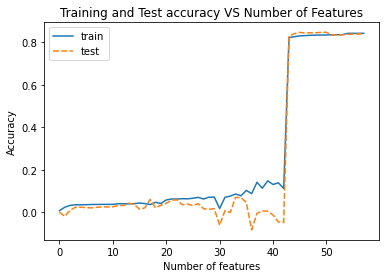

In [7]:
dict = {
    'num':num,
    'train': train_accuracy,
    'test': test_accuracy
}

df_plot = pd.DataFrame(dict)
sns.lineplot(data=df_plot[['train','test']]).set(xlabel='Number of features', ylabel='Accuracy', title="Training and Test accuracy VS Number of Features")